# Comparison of motif similarity at embryonic stages.
To assess the similarity of developmental stages in the two species based on what TFs are important in them.    

We counted motifs (PWMs) in dynamic ATAC peaks of our various developmental stages. We divided each motif's count by the total hits of the motif in all stages and then scaled the values in each stage.     

We could then calculate the correlation between stages and thus, we created a heatmap of correlation for the developmental stages of the two species.

# Preparation

In [96]:
from pybedtools import BedTool as BT

%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt

import pandas as pd

from scipy.stats import pearsonr

from collections import Counter

from sklearn import preprocessing

import warnings
warnings.filterwarnings('ignore')

In [97]:
superfams = pd.read_csv("/path/to/wpm2protein.tsv", sep='\t', header=None)
def order_things(x):
    return ';'.join(sorted(x.split(';')))

lot = []
for i,row in superfams.iterrows():
    if ';' not in row[1]:
        lot.append( row.tolist() )
    else:
        a,b = [';'.join(jj) for jj in zip(*sorted(zip(row[1].split(';'), row[2].split(';')), key= lambda x: int(x[0]) ))]
        lot.append( [row[0], a, b] )
        
superfams_ = pd.DataFrame(lot)

# We have a large set of motifs, which we group together by their protein
# e.g. AP-2_Average_15 and AP-2_Average_17 are different position weight matrices,
# but both assigned to the 'Tfap2e' transcription factor so we will group
# the two position weight matrices in one "motif"

# SFD here, maps the PWM names to unique protein numbers:
# 'AP-2_Average_15': '17068'
SFD = dict(superfams_[[0,1]].to_records(index=False))

# but then in cases like 'ARID_BRIGHT_RFX_Average_2',
# we have multiple proteins: 66;15742;15743;18247
# we will replace this long concatenation of numbers 
# with a unique number:
fuid = {}
c = 0
for v in SFD.values():
    if v not in fuid:
        fuid[v] = c
        c += 1
SFDu = {k:fuid[v] for k,v in SFD.items()}

### The mapped motifs:

In [11]:
dan_motif_bed = BT("/path/to/zebra_danRer10_pwm_hits.bed")
bla_motif_bed = BT("/path/to/amphi_pwm_hits.bed")
bla_motif_bed.head(2)

Sc0000000	5593	5598	Homeodomain_Average_626	6.60757208173	+
 Sc0000000	5695	5707	C2H2_ZF_Average_154	10.8804149236	+
 

### The ATACseq peaks

We have compiled a set of peaks that turn ON or OFF in a reasonable pattern during development,
and called these peaks 'dynamic'.     
    
Per stage we will only consider these dynamic peaks

In [13]:
# some helper functions to get the dynamic peaks per stage

a_dynamic = BT("/path/to/amphi_logicaldynamic_idr.bed")
def bla_stagepeaks(stage):
    sd = BT("/path/to/amphi_{}_idrpeaks.bed".format(stage))
    sd = sd.intersect(a_dynamic,u=True, nonamecheck=True)  
    return sd.sort()

z_dynamic = BT("/path/to/zebra_danRer10_logicaldynamic_idr.bed")
def dan_stagepeaks(stage):
    sd = BT("/path/to/zebra_danRer10_{}_idrpeaks.bed".format(stage))
    sd = sd.intersect(z_dynamic,u=True, nonamecheck=True)
    return sd.sort()

amphi_stages = ['8','15','36','60','hep']
zebra_stages = ['dome','shield','80epi','8som','24h','48h']

bla_peaks = [bla_stagepeaks(stage) for stage in amphi_stages]
dan_peaks = [dan_stagepeaks(stage) for stage in zebra_stages]

In [98]:
TFids = sorted(set(SFDu.values()))

In [99]:
# Here we get a dictionary, mapping the TF unique numbers to a total count per organism
# We will use this to normalize later on
doof = (BT("/path/to/zebra_danRer10_merged.bed")
        .sort()
        .intersect(dan_motif_bed, loj=True, sorted=True, nonamecheck=True)
        .to_dataframe())
dan_totals = Counter(doof['thickStart'].map(SFDu).dropna().astype(int))


doof = (BT("/path/to/amphi_merged.bed")
        .sort()
        .intersect(bla_motif_bed, loj=True, sorted=True, nonamecheck=True)
        .to_dataframe())
bla_totals = Counter(doof['thickStart'].map(SFDu).dropna().astype(int))

# dan_totals ~= {0: 3653,
#  1: 16725,
#  2: 1848,
#  3: 11946
#  ....}



# we cast the total counts in a list with a proper orger:
dan_normalizer = [dan_totals.get(x,1) for x in TFids]
bla_normalizer = [bla_totals.get(x,1) for x in TFids]

###  Mapping the motifs to peaks:

In [ ]:
# Here we make a dataframe per stage per organism
# Each DataFrame corresponds to one stage and maps motifs to the peaks that were active on
# that stage. We use the LEFT OUTER JOIN function of bedtools to join motifs to peaks:
bla_lojs = [(stage
                .sort()
                .intersect(bla_motif_bed, sorted=True, loj=True, nonamecheck=True)
                .to_dataframe()) for stage in bla_peaks]
dan_lojs = [(stage
                .sort()
                .intersect(dan_motif_bed, sorted=True, loj=True, nonamecheck=True)
                .to_dataframe()) for stage in dan_peaks]

In [21]:
# For example, the DF for the first stage of amphioxus:
bla_lojs[0].head(2)

,chrom,start,end,name,score,strand,thickStart,thickEnd,itemRgb
0,Sc0000000,311943,312518,Sc0000000,311942,311946,C2H2_ZF_Average_177,5.460094,+
1,Sc0000000,311943,312518,Sc0000000,312028,312035,Grainyhead_M6529_1.02,7.510921,+


In [61]:
# Finally, we make a DF with counts for each TF in each stage:
# These are the counts in the dynamic peaks
ddf = pd.DataFrame(TFids)
ddf.columns = ['fam']

for en,stage in enumerate(zebra_stages):
    ddf[stage] = ddf['fam'].map(Counter(dan_lojs[en]['thickStart'].dropna().map(SFDu).dropna().astype(int)))
    
ddf.set_index('fam', inplace=True, drop=True)

ddf = ddf.T.fillna(1)
ddf

fam,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
dome,161,729,74,389,178,854,1924,701,140,2609,...,38,4441,50,166,452,91,142,0,566,1004
shield,409,1931,165,1014,419,2058,5522,1855,336,7093,...,136,10826,135,443,1241,176,471,0,1741,2660
80epi,638,2991,228,1657,708,3119,9240,2965,520,11323,...,282,17599,234,725,2060,260,846,0,3015,4474
8som,756,3693,298,2357,904,3708,12270,3884,763,13939,...,402,23813,318,964,2790,408,1236,0,4242,5956
24h,785,3911,333,2504,963,3775,13310,4044,861,14794,...,450,26475,417,1132,3176,487,1452,0,4843,6715
48h,672,3333,335,2185,775,3078,11303,3355,785,12285,...,420,23411,367,965,2712,433,1294,0,4150,5916


In [62]:
# And the same for amphioxus
bdf = pd.DataFrame(TFids)
bdf.columns = ['fam']
for en,stage in enumerate(amphi_stages):
    bdf[stage] = bdf['fam'].map(Counter(bla_lojs[en]['thickStart'].dropna().map(SFDu).dropna().astype(int)))
    
bdf.set_index('fam', inplace=True, drop=True)

bdf = bdf.T.fillna(1)
bdf

fam,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
8,73,257,50,251,95,357,1093,438,73,789,...,22,2330,52,76,223,26,94,0,307,593
15,196,618,172,707,224,885,2838,1115,177,2482,...,72,6641,135,221,504,103,343,0,687,1550
36,219,652,177,942,266,998,3234,1287,200,2979,...,101,8168,153,275,588,140,500,0,766,2003
60,236,761,217,1155,297,1082,3316,1337,244,3079,...,123,10328,209,302,669,190,524,0,831,2391
hep,212,608,144,998,260,897,2761,1241,207,2389,...,77,8786,249,266,555,191,400,0,665,2306


In [64]:
# we divide the count in each stage by the total count
bdf = bdf/bla_normalizer
ddf = ddf/dan_normalizer
bdf

fam,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
8,0.061448,0.071688,0.053763,0.052129,0.064189,0.075524,0.068462,0.068246,0.068224,0.060133,...,0.042553,0.050174,0.055556,0.059006,0.072473,0.030806,0.051450,0.0,0.079472,0.052725
15,0.164983,0.172385,0.184946,0.146833,0.151351,0.187222,0.177764,0.173730,0.165421,0.189162,...,0.139265,0.143008,0.144231,0.171584,0.163796,0.122038,0.187739,0.0,0.177841,0.137815
36,0.184343,0.181869,0.190323,0.195639,0.179730,0.211128,0.202568,0.200530,0.186916,0.227041,...,0.195358,0.175890,0.163462,0.213509,0.191095,0.165877,0.273673,0.0,0.198291,0.178092
60,0.198653,0.212273,0.233333,0.239875,0.200676,0.228898,0.207704,0.208320,0.228037,0.234662,...,0.237911,0.222404,0.223291,0.234472,0.217420,0.225118,0.286809,0.0,0.215118,0.212590
hep,0.178451,0.169596,0.154839,0.207269,0.175676,0.189761,0.172941,0.193362,0.193458,0.182075,...,0.148936,0.189199,0.266026,0.206522,0.180370,0.226303,0.218938,0.0,0.172146,0.205032


In [65]:
# At this point, some TFs have 0 counts, so lets clean them out:
btodrop = set(bdf.T[bdf.sum() ==0].index.values)
dtodrop = set(ddf.T[ddf.sum() ==0].index.values)

todrop = btodrop.union(dtodrop)

bdf = bdf.drop(todrop, axis=1)
ddf = ddf.drop(todrop, axis=1)

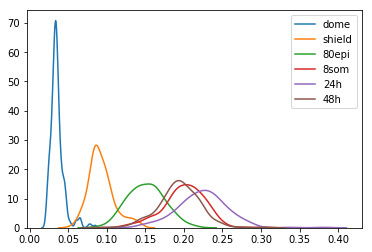

In [66]:
# the distributions of the various stages at this point:
for irow,row in ddf.iterrows():
    sns.kdeplot(row)

In [67]:
# let's scale the counts in order to make stages comparable
ddf.loc[:,:] = preprocessing.scale(ddf.values, axis=1)
bdf.loc[:,:] = preprocessing.scale(bdf.values, axis=1)

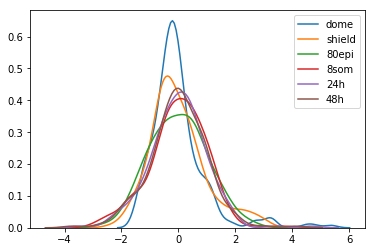

In [68]:
# the distributions after scaling:
for irow,row in ddf.iterrows():
    sns.kdeplot(row)

## The final table:
In the end, we have a scaled count per motif for each organism-stage.
For example the first 5 TF scaled counts in zebrafish-shield look like this:

In [82]:
ddf.loc['shield',:].head()

fam
0    1.143067
1    1.350141
2   -0.201232
3   -0.462287
4   -0.440515
Name: shield, dtype: float64

We can then get a corellation between any two cases

In [87]:
scaled_counts_in_zebra_shield = ddf.loc['shield',:]
scaled_counts_in_amphi_hep = bdf.loc['hep',:]

# The first value if the pearson metric and the second is the metric's pvalue,
# how certain we are for the metric.
pearsonr(scaled_counts_in_zebra_shield.values, scaled_counts_in_amphi_hep.values)

(-0.18212360335862862, 0.0044786665950091106)

In [89]:
# We can make a table with pair-wise correlations for all stages
TABLE = pd.DataFrame()
for dstage in zebra_stages:
    for bstage in amphi_stages:
        TABLE.loc[dstage, bstage] = pearsonr(ddf.loc[dstage].values,bdf.loc[bstage].values)[0]
TABLE

,8,15,36,60,hep
dome,0.472447,0.413344,-0.020947,-0.233493,-0.217931
shield,0.427724,0.620226,0.304749,-0.079934,-0.182124
80epi,0.248738,0.577668,0.509119,0.113895,-0.064038
8som,-0.016492,0.297138,0.525042,0.289232,0.156917
24h,-0.091795,0.182115,0.427101,0.263281,0.264657
48h,-0.225320,0.018198,0.359862,0.292274,0.196003


We can visualize the table in a heatmap:

In [94]:
sns.set_style('white')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

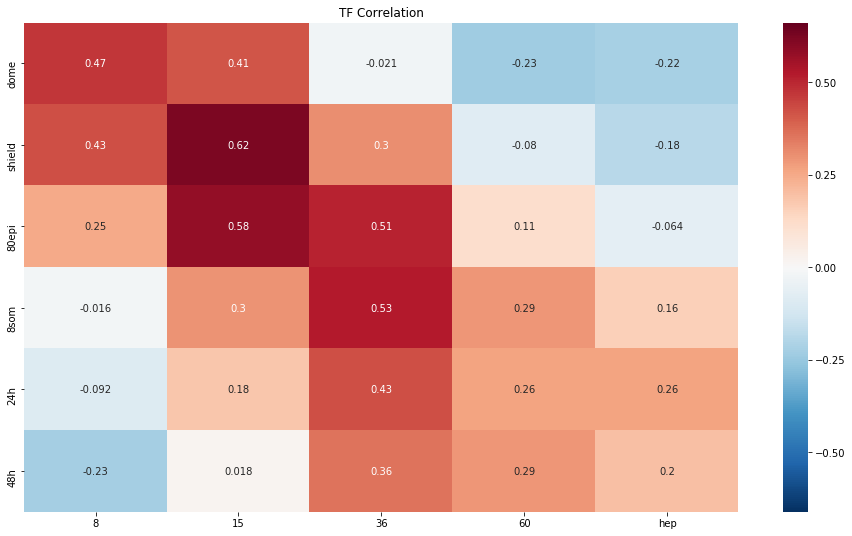

In [73]:

fig, ax = plt.subplots(figsize=(16,9))
sns.heatmap(TABLE,
            annot=True,
            cmap="RdBu_r",
#            linewidth=0.1,
            vmax=0.66, vmin=-0.66,
            ax=ax
           )

ax.set_title("TF Correlation")

Or we can plot the minimum distance per amphioxus stage, to show the hourglass behaviour

In [90]:
x = [ 0, 1, 2, 3, 4]
labels = ['8h','15h','36h','60h','hepatic']

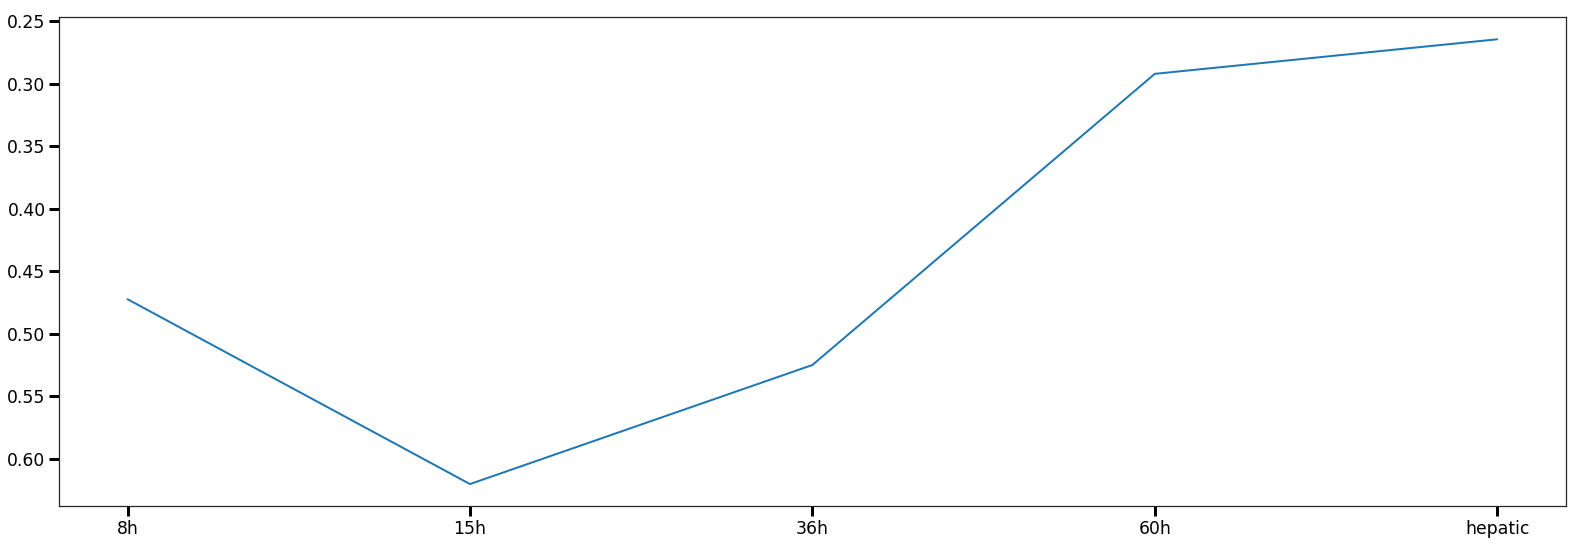

In [93]:
fig, ax = plt.subplots(figsize=(27,9))

ax.plot( TABLE.max().values, linewidth=2)

ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.tick_params(direction ='out',
               length=10, width=3, colors='black',labelsize='xx-large')
ax.invert_yaxis()